seat rotation
---

partners sat in seat X one day, then seat X+1, then X+2...
"Tony" liked seat 24. So everyone skipped 24.

>David,
>
>Here’s the seat rotation plan we used in NZ.   According to the guide, it was determined by some mathematician.  Our number was 22.  The first day I was 5 seats behind the driver, the next day we moved to #23.  “Tony” liked to sit way in the back so we all skipped 24 , then went to #1 spot.
>
>And as I mentioned , there were a few open seats so Dad & I would split up to have more space.  Of course,  people forgot where they sat and sometimes caused confusion  :) !  Anyway, it was good to have some kind of plan so the same people didn’t always get the front  / best view.
>
>Do you think it is just random?

![seat](seats.png)

Give each seat a row and a side.

In [1]:
seat_numbers = ['Driver', 'Front Door',1,14,18,10,7,21,15,4,22,8,16,'toilet',3,'back door',9,12,5,23,20,17,11,2,19,6,24,13]

rows = [ [row, row] for row in range(14)]
rows = [ row_num
        for row in rows
        for row_num in row
       ]
RLs = [ ['R', 'L'] for row in range(14)]
RLs = [ side
       for row in RLs
       for side in row ]
seats = {
    seat_number:{
        'row':row,
        'side':side,
        'side_no':(0 if side == 'L' else 1)
    }
    for seat_number, row, side in zip(seat_numbers, rows, RLs)
}

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_seat_position(seat_key):
    seat = seats[seat_key]
    row = seat['row']
    side_no = seat['side_no']
    return [row, side_no]

def seat_distance(seat1, seat2):
    position1 = np.array(get_seat_position(seat1))
    position2 = np.array(get_seat_position(seat2))
    return np.linalg.norm(position2-position1)

In [3]:
distances = [ [seat1, seat2, seat_distance(seat1, seat2)]
             for seat1 in seats
             for seat2 in seats
            ]

# # sns.heatmap(distances)


<Axes: >

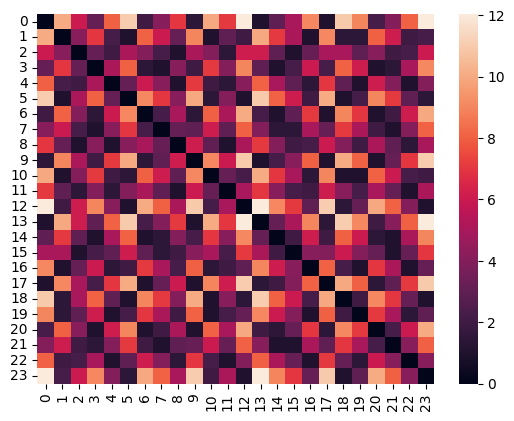

In [8]:
import pandas as pd
df = pd.DataFrame(distances, columns = ['seat1','seat2','distance'])
sorted_distance_df = df.where(~((df == 'toilet') | (df == 'back door')|(df == 'Driver')|(df == 'Front Door')), other = np.nan).dropna().sort_values(by = ['seat1','seat2']).astype(float)
distance_matrix = sorted_distance_df.to_numpy()
distance_matrix = distance_matrix[:,2].reshape((24,24)).astype(float)

sns.heatmap(sorted_distance_df['distance'].to_numpy().reshape((24,24)))

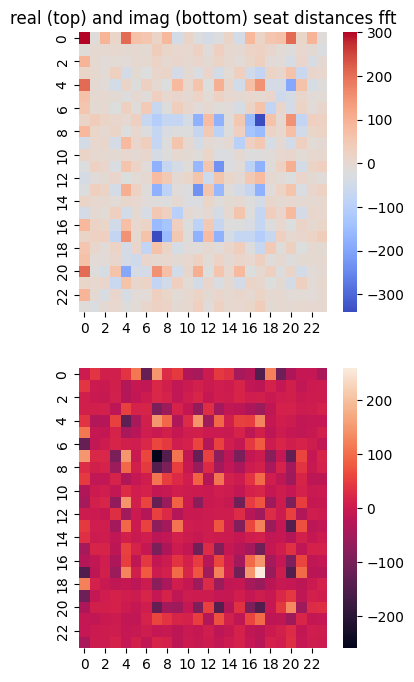

In [47]:
#create the fft
distfft = np.fft.fft2(distance_matrix)

#set up a figure
fig, ax = plt.subplots(figsize = (4,8), nrows = 2, ncols=1)

realmap = sns.heatmap(np.real(distfft), ax=ax[0], vmax = 300, cmap='coolwarm')
realmap.set_title("real (top) and imag (bottom) seat distances fft")

immap = sns.heatmap(np.imag(distfft), ax = ax[1])
# immap.set_title("imag part seat distances fft")
plt.show()

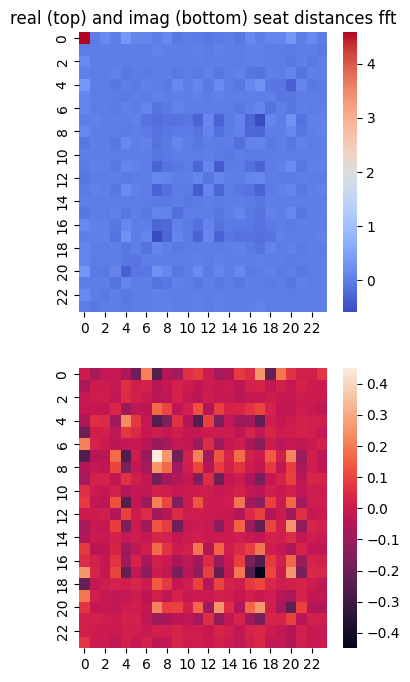

In [49]:
#create the fft
invdistfft = np.fft.ifft2(distance_matrix)

#set up a figure
fig, ax = plt.subplots(figsize = (4,8), nrows = 2, ncols=1)

invrealmap = sns.heatmap(np.real(invdistfft), ax=ax[0], cmap='coolwarm')
invrealmap.set_title("real (top) and imag (bottom) seat distances fft")

invimmap = sns.heatmap(np.imag(invdistfft), ax = ax[1])
# immap.set_title("imag part seat distances fft")
plt.show()

In [50]:
def get_neighbors(seat, include_toilet = False):
    """give a seat key. Get the keys of its neighbors.
    Optionally include non-seats."""
    this_seat = seats[seat]
    this_row = this_seat['row']
    this_side = this_seat['side']
    #get forward and back neighbors
    f_b_neighbors = [
        neighbor for neighbor in seats
        if seats[neighbor]['side'] == this_side and abs(seats[neighbor]['row'] - this_row) == 1
    ]
    #get neighbor to the side
    side_neighbor = [
        neighbor for neighbor in seats
        if seats[neighbor]['side'] != this_side and seats[neighbor]['row'] == this_row
    ]
    if include_toilet:
        return f_b_neighbors + side_neighbor
    else:
        return [
            neighbor for neighbor in f_b_neighbors + side_neighbor
            if type(neighbor) != str
        ]

In [51]:
get_neighbors(5)

[9, 20, 23]

In [52]:
get_neighbors('Driver')

[1]

In [53]:
get_neighbors('Driver', True)

[1, 'Front Door']

In [81]:
def get_previous_neighbor_distances(seat:int):
    """Given a seat, look back at the seat sat in the previous cycle.
    Get its neighbors, and find the seats they are in one
    cycle ahead. Get the distances between these."""
    last_seat = (seat - 1)%24
    last_seat_neighbors = get_neighbors(last_seat)
    new_distances = []
    for old_neighbor in last_seat_neighbors:
        new_seat = (old_neighbor + 1)%24
        new_distance = seat_distance(new_seat, seat)
        new_distances.append(new_distance)
    return np.array(new_distances)

In [82]:
get_previous_neighbor_distances(3)

array([5.        , 4.        , 1.41421356])

In [66]:
seat_df = pd.DataFrame(seats).T
# seat_df['neighbors']

In [72]:
seat_df['neighbors'] = seat_df.reset_index()['index'].apply(lambda ind: get_neighbors(ind, True))

In [74]:
seat_df['neighbors_no'] = seat_df.reset_index()['index'].apply(lambda ind: get_neighbors(ind, False))

In [78]:
seat_df['previous_neighbors'] = seat_df.reset_index()['index'].apply(lambda ind: get_neighbors((ind-1)%24, False) if type(ind) != str else np.nan)

KeyError: 0

In [83]:
seats.keys()

dict_keys(['Driver', 'Front Door', 1, 14, 18, 10, 7, 21, 15, 4, 22, 8, 16, 'toilet', 3, 'back door', 9, 12, 5, 23, 20, 17, 11, 2, 19, 6, 24, 13])